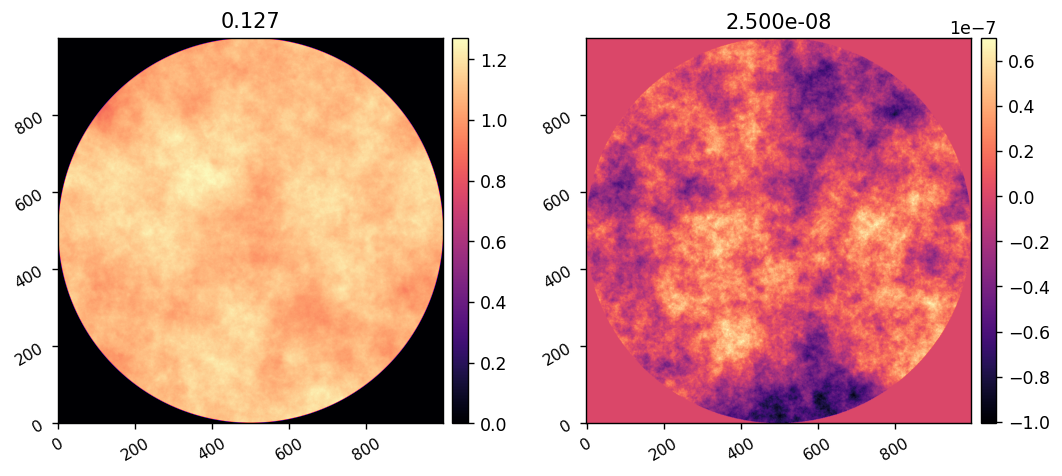

array(2.5e-08)

In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob_2 as cscoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])


influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


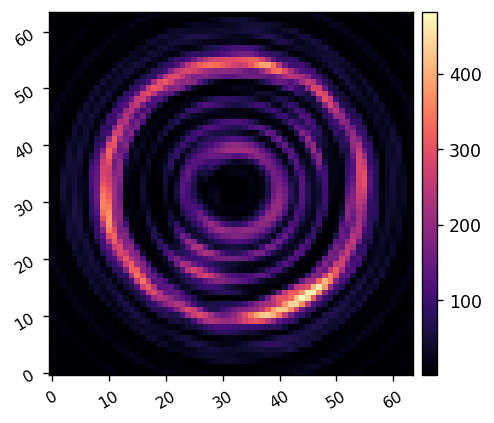

In [14]:
model = cscoob.CORO(use_llowfsc=True)
model.llowfsc_fl = 200*u.mm
model.use_fpm = True

model.WFE = WFE

wfs = model.calc_wfs()
im = xp.abs(wfs[-1])**2

imshow1(im)
# imshow3(xp.abs(wfs[-2]), xp.abs(wfs[-2]), im, npix2=model.npix, lognorm2=True, vmin2=1e-5, 
#         pxscl1=model.lyot_pupil_diam/model.npix, pxscl2=model.lyot_pupil_diam/model.npix,
#         patches1=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
#                   Circle((0,0), 25.4/2, fill=False, color='cyan'),],
#         patches2=[Circle((0,0), 8.6/2, fill=False, color='cyan'),],
#                   )

# model.use_llowfsc = False
# im = model.snap()
# imshow1(im, lognorm=True)

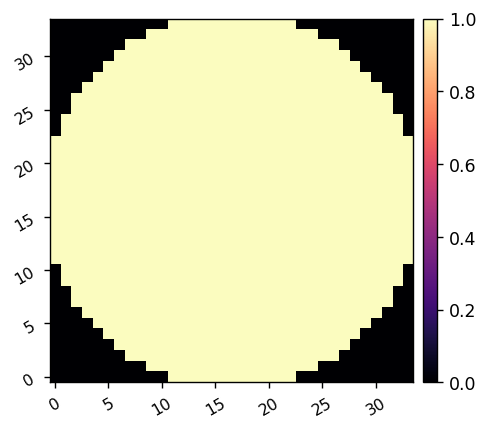

array(952)

In [31]:
dm_mask = xp.ones((model.Nact,model.Nact), dtype=bool)
xx = (xp.linspace(0, model.Nact-1, model.Nact) - model.Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(model.Nact+1)/2] = 0
imshow1(dm_mask)
dm_mask.sum()

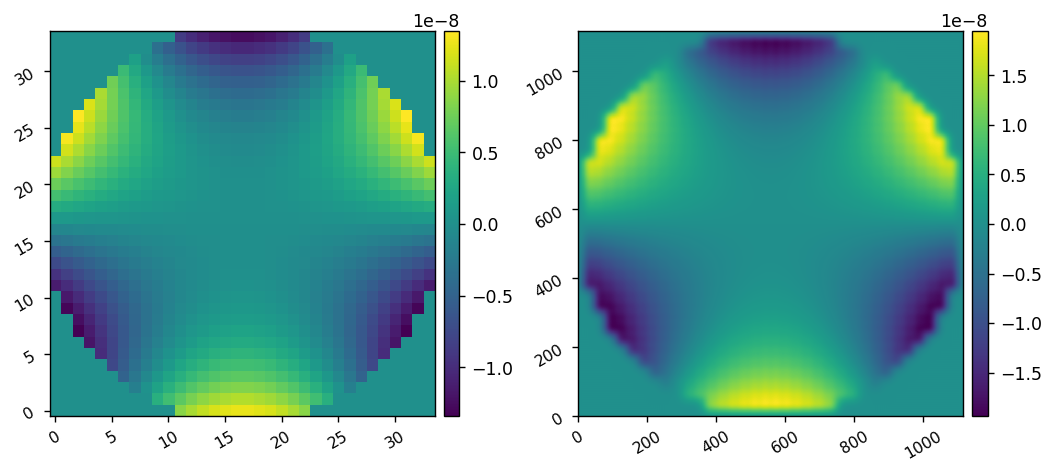

In [32]:
dm_zernikes = lina.utils.create_zernike_modes(dm_mask, nmodes=25 + 1)[1:]
model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface(), cmap1='viridis', cmap2='viridis')
model.reset_dm()


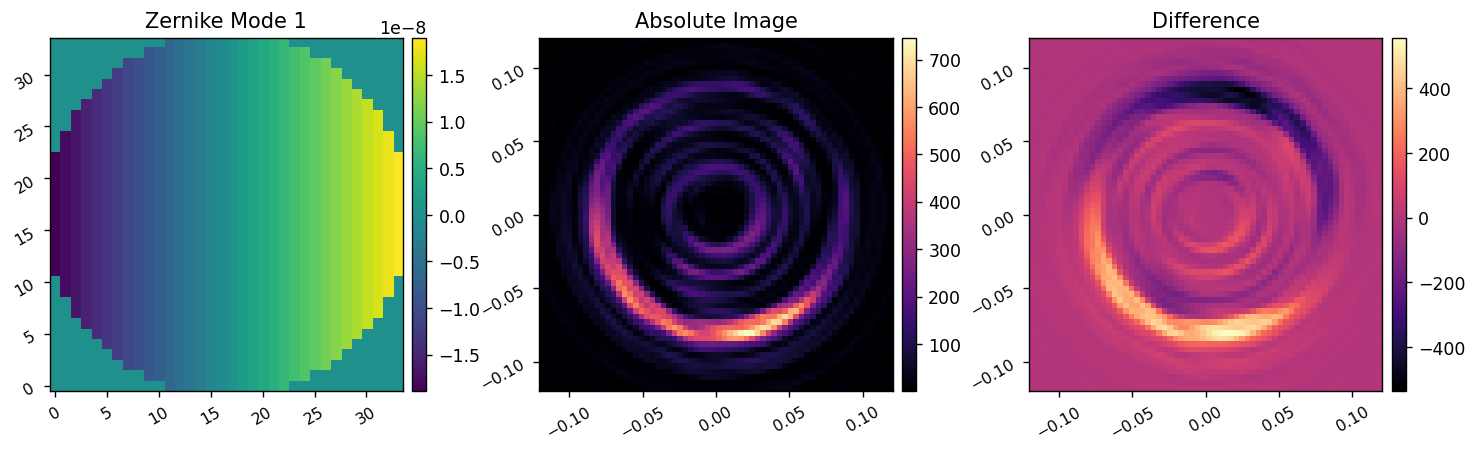

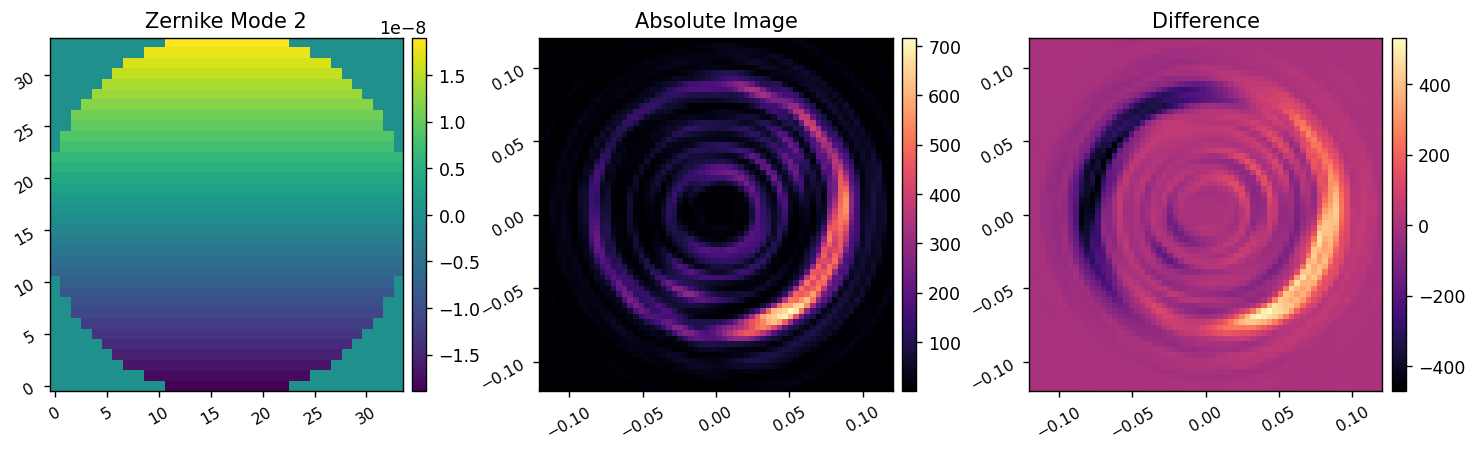

In [42]:
amp = 10e-9

model.WFE = WFE
model.reset_dm()


im_ref = model.snap()

N = 2
responses = xp.zeros((N, model.nllowfsc**2))
for i in range(N):
    mode = dm_zernikes[i]
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    # diff = im_pos-im_ref
    # responses[i] = diff.flatten()/amp
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
            cmap1='viridis')

response_matrix = responses.T

In [43]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(1.10602814)

In [44]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-15)

# load in the low-order WFE time series

4.357759994879304e-08 -1.3083378526169591e-08
4.357759994879304e-08 1.3083378526169591e-08
4.549925286151502e-08 4.549925286151502e-08


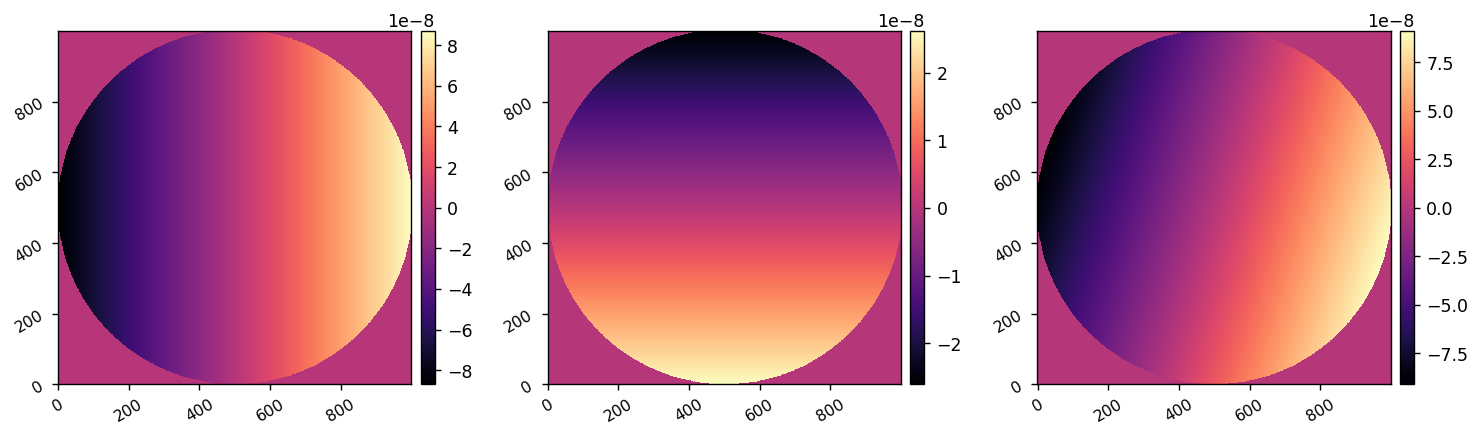

In [38]:
from astropy.io import fits
import copy

zmodes = lina.utils.create_zernike_modes(model.APERTURE, nmodes=25 + 1)[1:]

pointing_error_time_series = xp.array(fits.getdata('pointing_error_time_series.fits'))
times = pointing_error_time_series[0]
Nt = times.shape[0]
coeff = pointing_error_time_series[1:] * 100e-9

pointing_modes = copy.copy(zmodes[:2]).reshape(2, npix**2).T

i = 1500
print(coeff[0,i], coeff[1,i])
tip = coeff[0,i]*pointing_modes[:,0].reshape(npix,npix)
tilt = coeff[1,i]*pointing_modes[:,1].reshape(npix,npix)
lo_wfe = pointing_modes.dot(xp.array(coeff[:,i])).reshape(npix,npix)

print(np.sqrt(np.mean(np.square(tip[model.APMASK]))), np.sqrt(np.mean(np.square(tilt[model.APMASK]))))
print(xp.sqrt(coeff[0,i]**2 + coeff[1,i]**2), np.sqrt(np.mean(np.square(lo_wfe[model.APMASK]))))
imshow3(tip, tilt, lo_wfe)

In [11]:
N = 100
wfe_times = xp.zeros(N)
pointing_wfe = xp.zeros((N, npix, npix))
for i in range(N):
    a = xp.array(coeff[:,1500 + 100*i])
    wfe = pointing_modes.dot(a).reshape(npix,npix)
    pointing_wfe[i] = wfe
    wfe_times[i] = times[100*i]

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['image.origin']='lower'

import matplotlib
from matplotlib.animation import FFMpegWriter, PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.html'] = 'html5'
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':'nearest'})

def create_anim(arrs1):
    numframes = arrs1.shape[0]
    print(numframes)

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5),dpi=125)
    
    im1 = ax.imshow(arrs1[0,:,:],)
    im1_title = ax.set_title(f'WFE: Time = {0.0:.2e}s', fontsize = 18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.075)
    cbar = fig.colorbar(im1, cax=cax)

    def animate(i):
        im1.set_data(arrs1[i,:,:])
        im1_title.set_text(f'WFE: Time = {wfe_times[i]:.2e}s')
        im1.set_clim(vmin=np.min(arrs1[i,:,:]), vmax=np.max(arrs1[i,:,:]))

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=numframes, )
    return anim

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 5.0 x 5.0 to 4.992 x 4.992
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 624x624 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2bkgju9b/temp.m4v


100


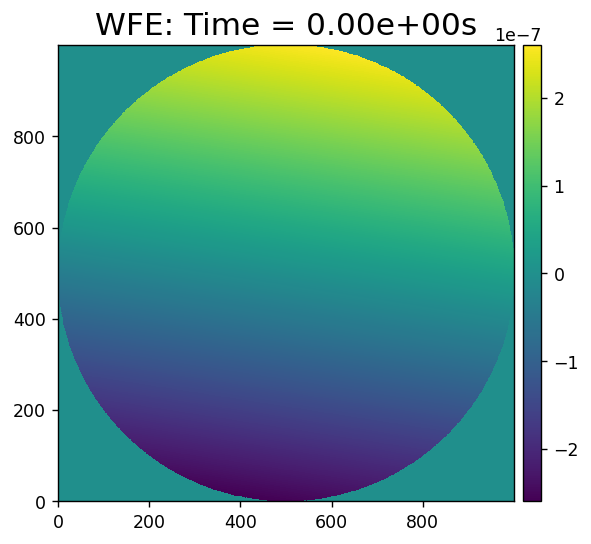

In [15]:
create_anim(pointing_wfe.get())

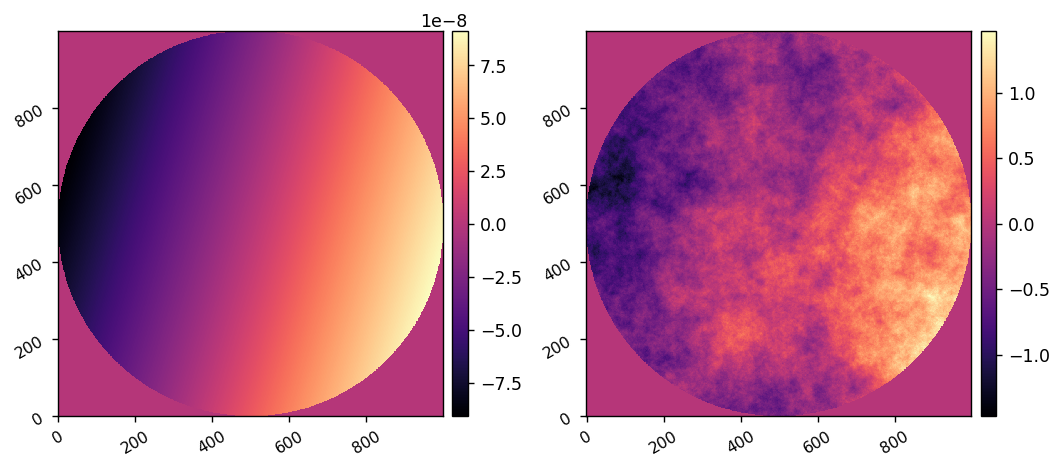

In [39]:
model.reset_dm()
model.WFE = WFE * xp.exp(1j*2*np.pi*lo_wfe/model.wavelength_c.to_value(u.m))
imshow2(lo_wfe, xp.angle(model.WFE))

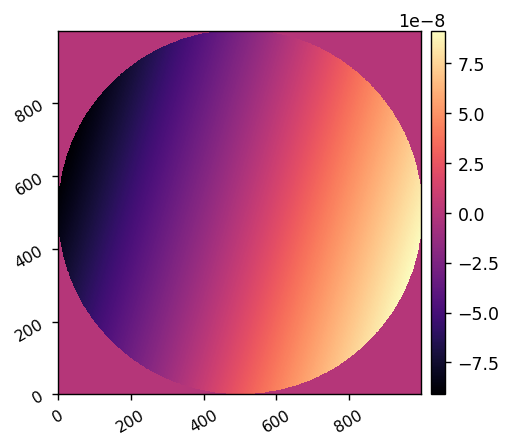

In [20]:
imshow1(lo_wfe)

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


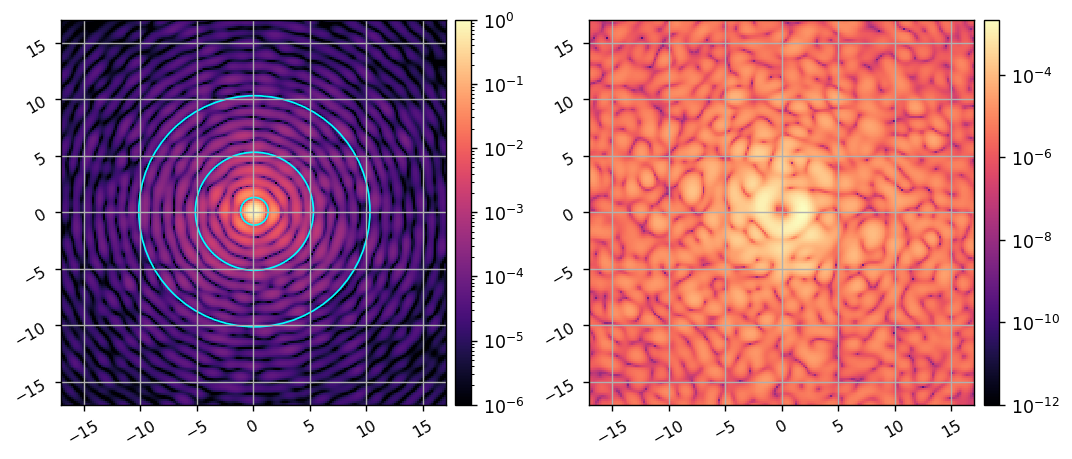

In [49]:
reload(cscoob)
reload(scoobpsf.props)
coro_model = cscoob.CORO()
coro_model.WFE = WFE
# coro_model.WFE = WFE * xp.exp(1j*2*np.pi*lo_wfe/model.wavelength_c.to_value(u.m))
ref_psf = coro_model.snap()
coro_model.Imax_ref = xp.max(ref_psf)

coro_model.use_fpm = True

wfs = coro_model.calc_wfs()
coro_im = xp.abs(wfs[-1])**2

imshow2(ref_psf/coro_model.Imax_ref, im, lognorm=True, vmin1=1e-6, vmin2=1e-12,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])

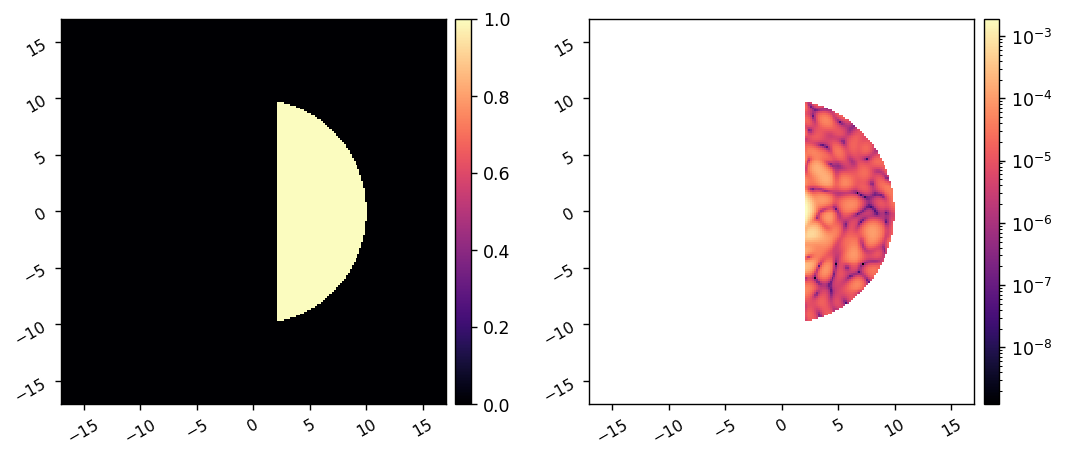

In [51]:
iwa = 2
owa = 10

control_mask = lina.utils.create_annular_focal_plane_mask(coro_model, iwa, owa, edge=2, shift=(0,0), rotation=0)
imshow2(control_mask, coro_im*control_mask, lognorm2=True, pxscl=model.psf_pixelscale_lamD)

In [54]:
coro_model.reset_dm()

poke_modes = lina.utils.create_all_poke_modes(coro_model.dm_mask)

epsilon = 1e-9 # poke amplitudes (DM surface)
jac = lina.efc.calibrate(coro_model, poke_modes, epsilon, control_mask, )

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=68.436 sec.
Jacobian built in 68.436 sec


Beginning closed-loop EFC.
	Running iteration 1/5.
Using model to compute electric field


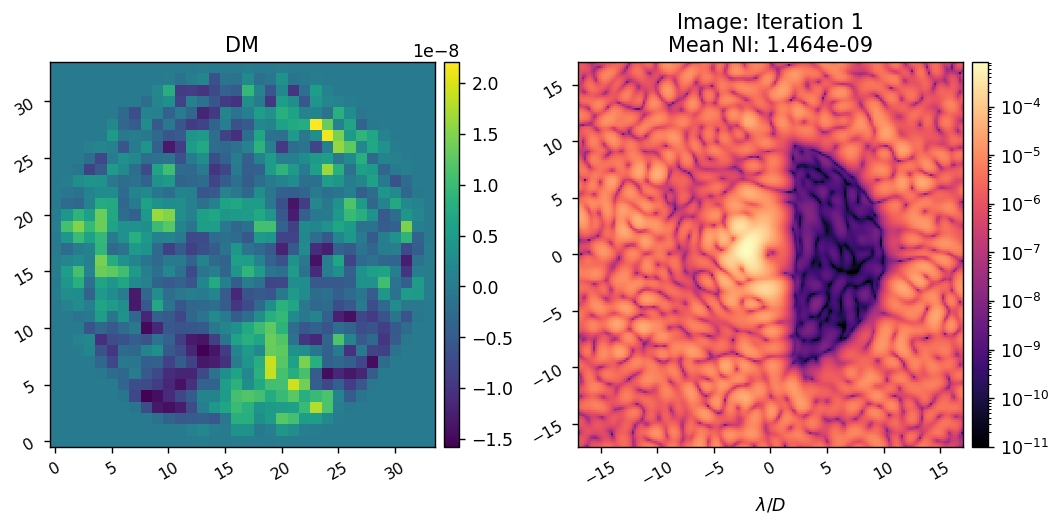

	Running iteration 2/5.
Using model to compute electric field


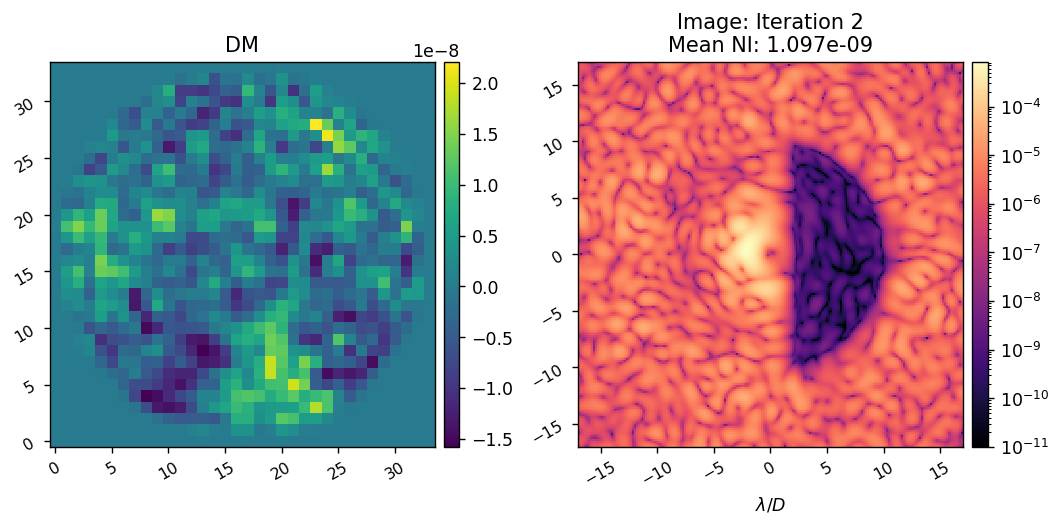

	Running iteration 3/5.
Using model to compute electric field


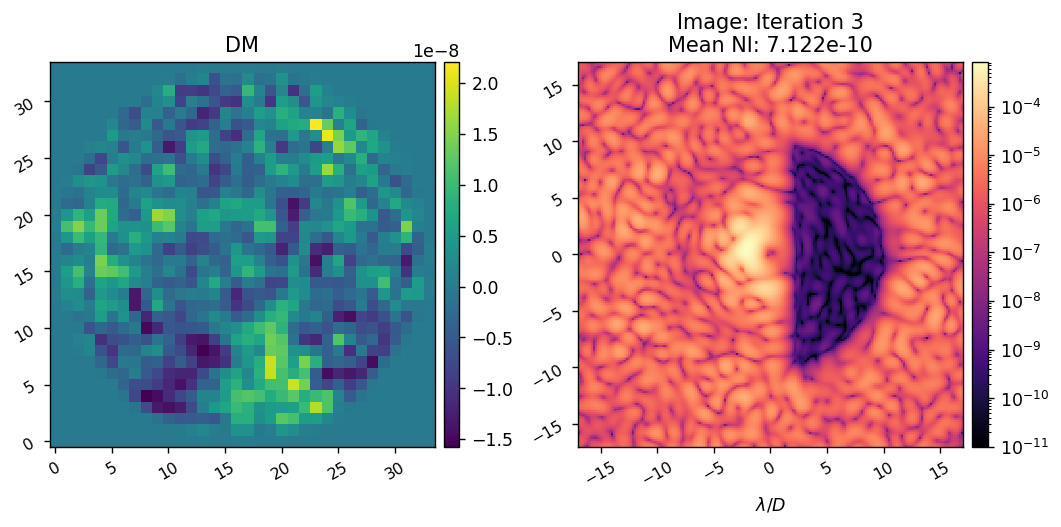

	Running iteration 4/5.
Using model to compute electric field


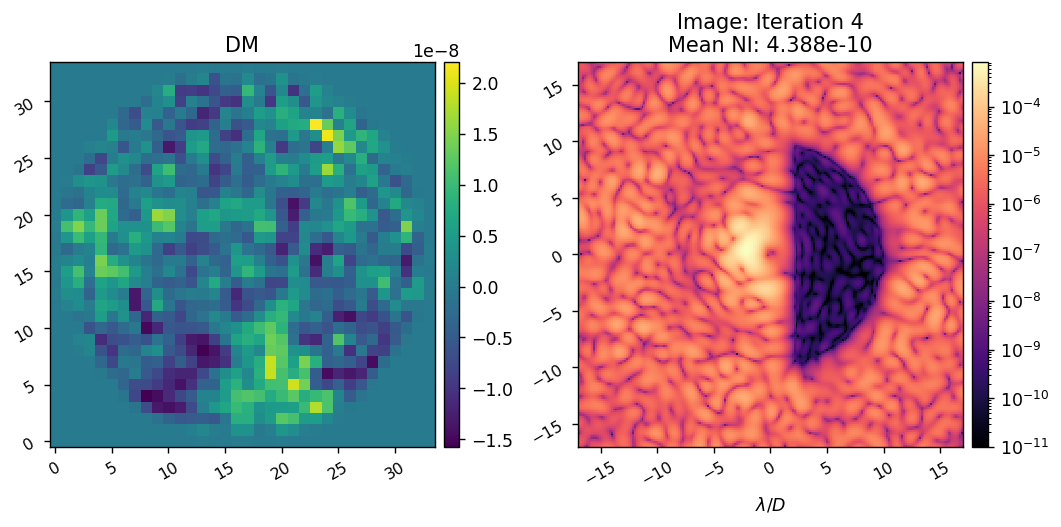

	Running iteration 5/5.
Using model to compute electric field


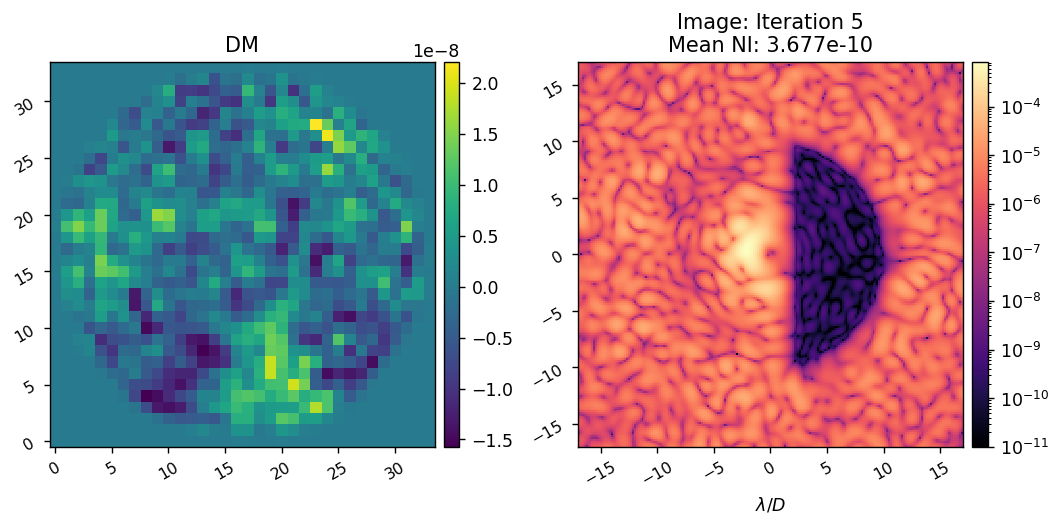

EFC completed in 3.417 sec.


In [69]:
# coro_model.reset_dm()

# control_matrix = lina.utils.beta_reg(jac, -1)
control_matrix = lina.utils.TikhonovInverse(jac, 1e-1)

images, efields,commands = lina.efc.run(coro_model, 
                                                    poke_modes,
                                                    control_matrix,
                                                    control_mask, 
                                                    # est_fun, est_params, 
                                                    loop_gain=0.1, 
                                                    leakage=0,
                                                    iterations=5, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    )

In [70]:
dark_hole_command = commands[-1]
utils.save_fits('dark_hole_command.fits', dark_hole_command)

Saved data to:  dark_hole_command.fits


(1156, 2) (1000000, 2)


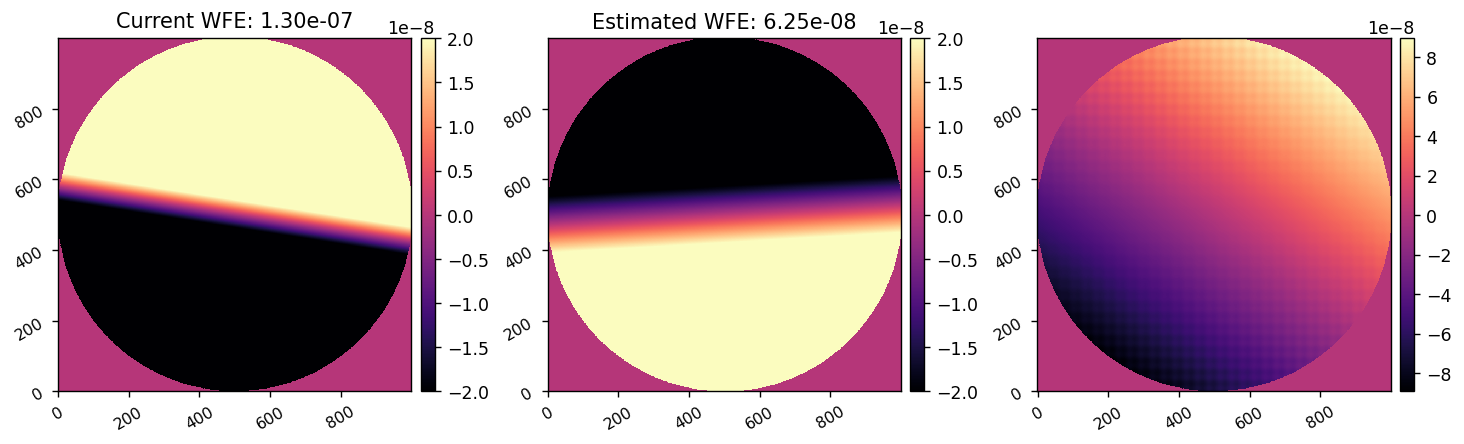

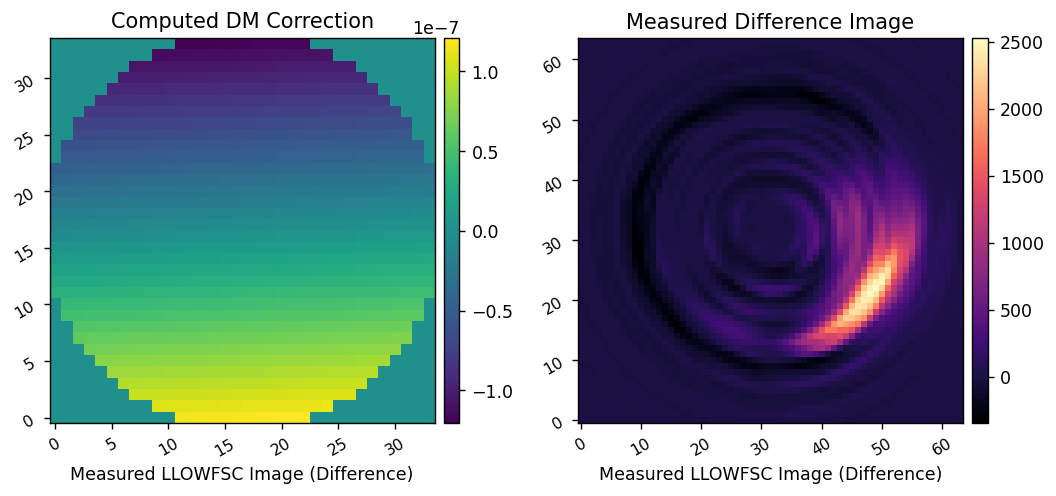

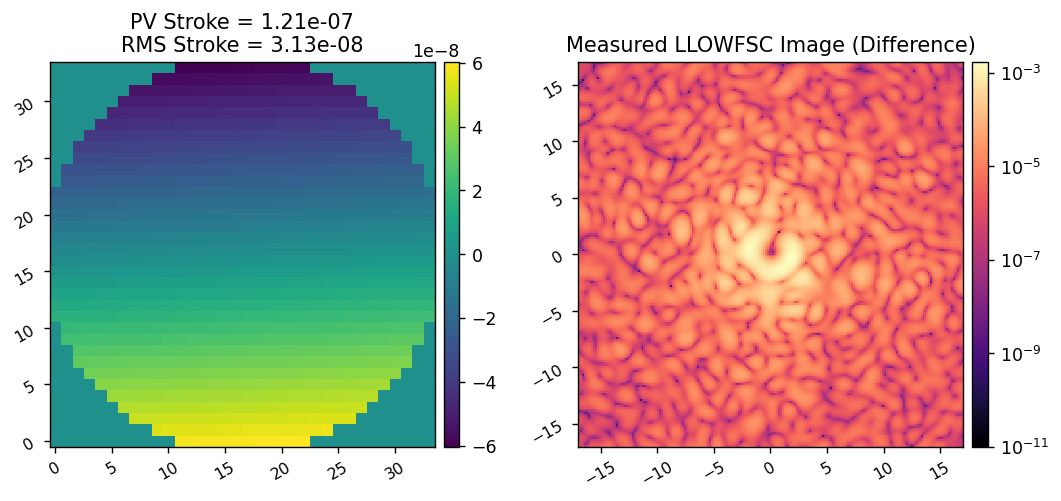

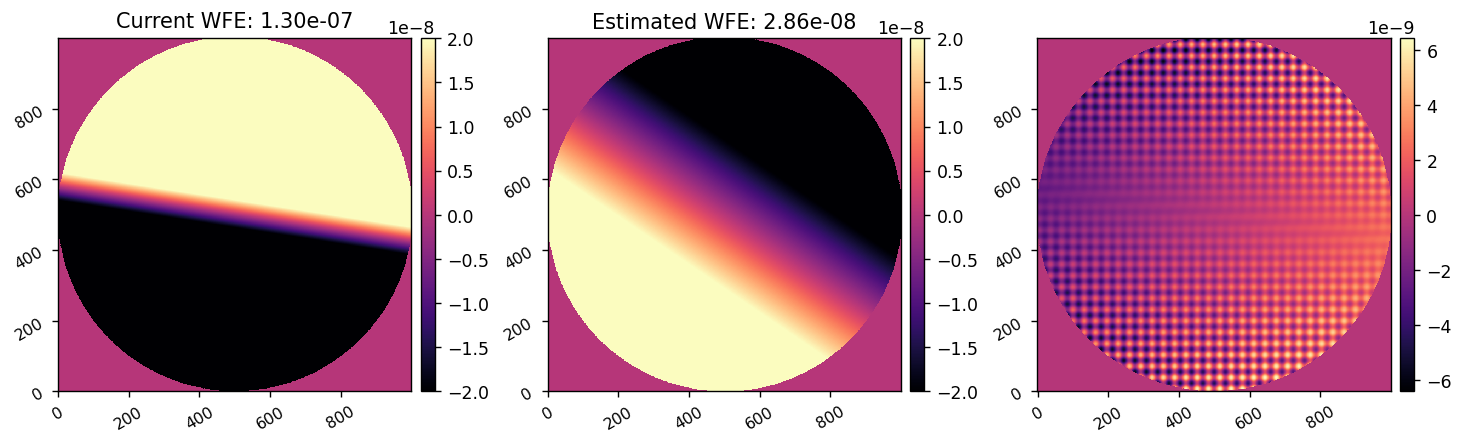

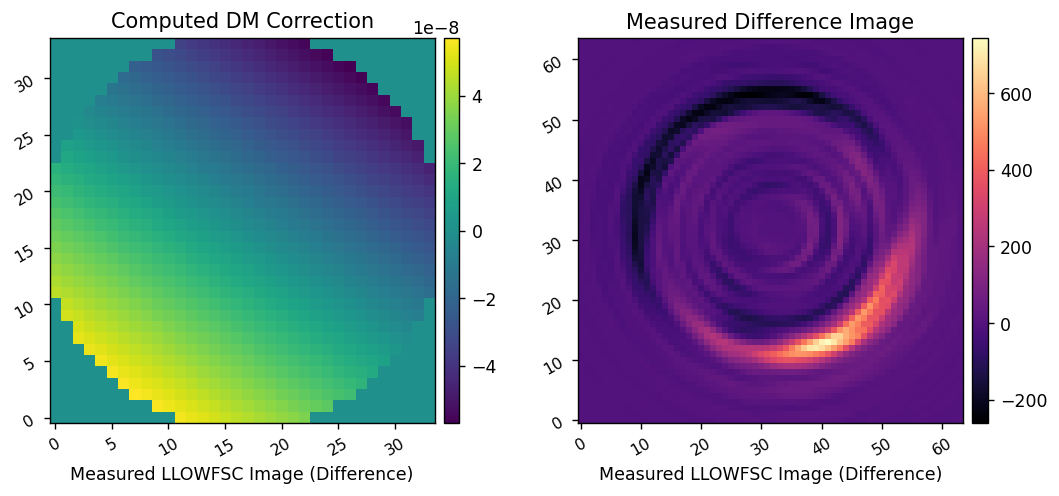

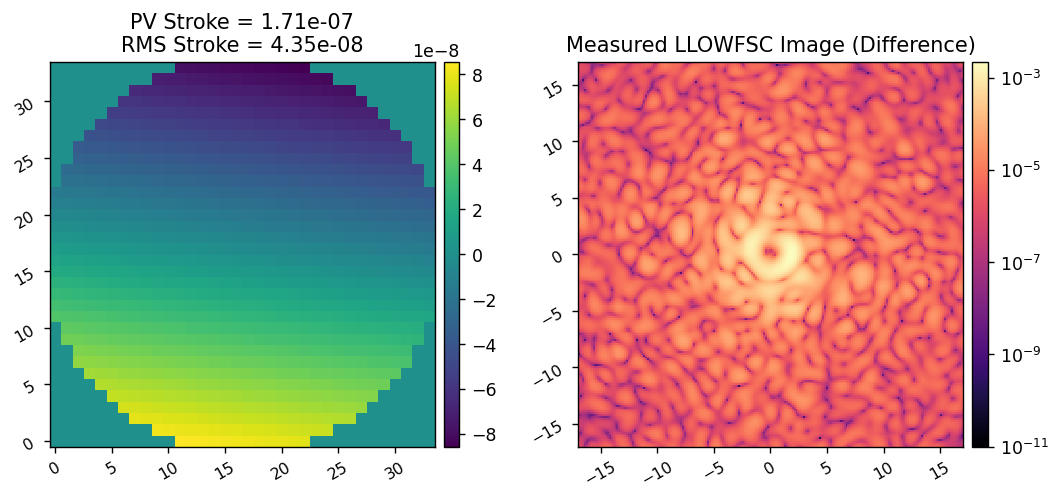

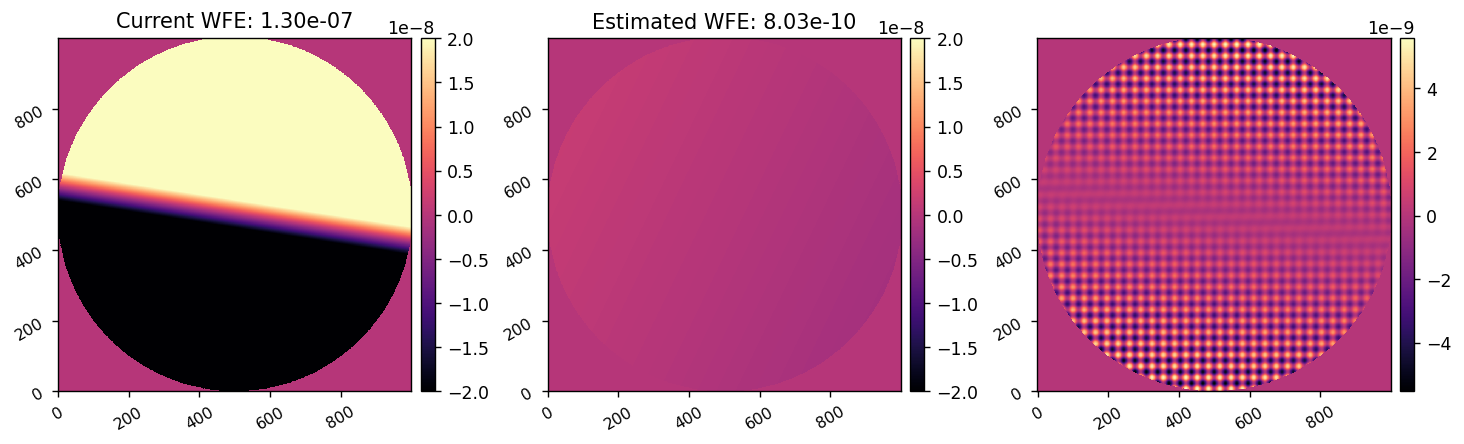

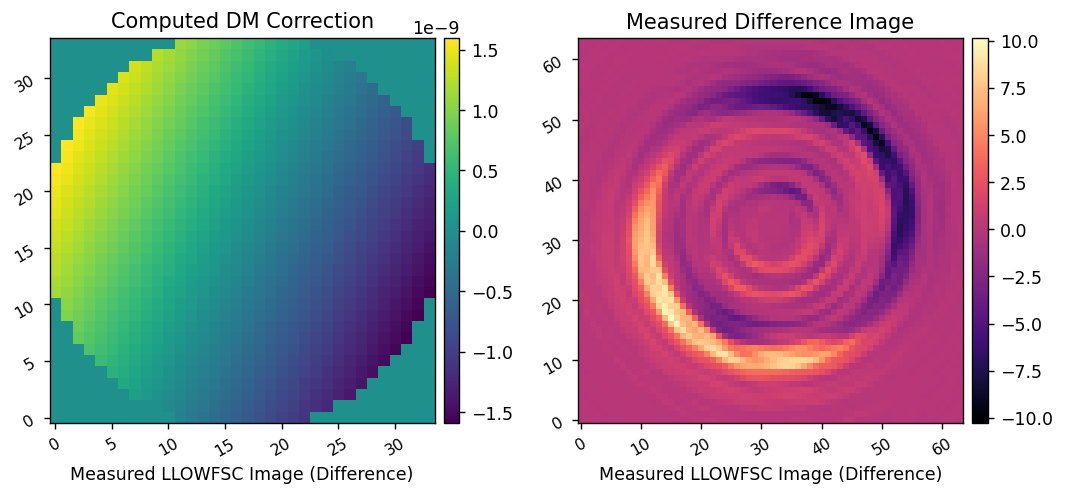

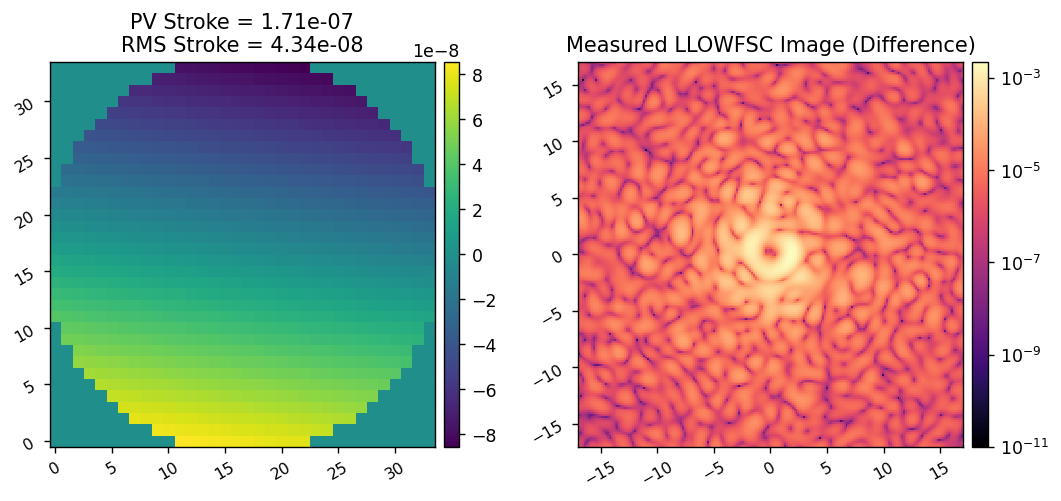

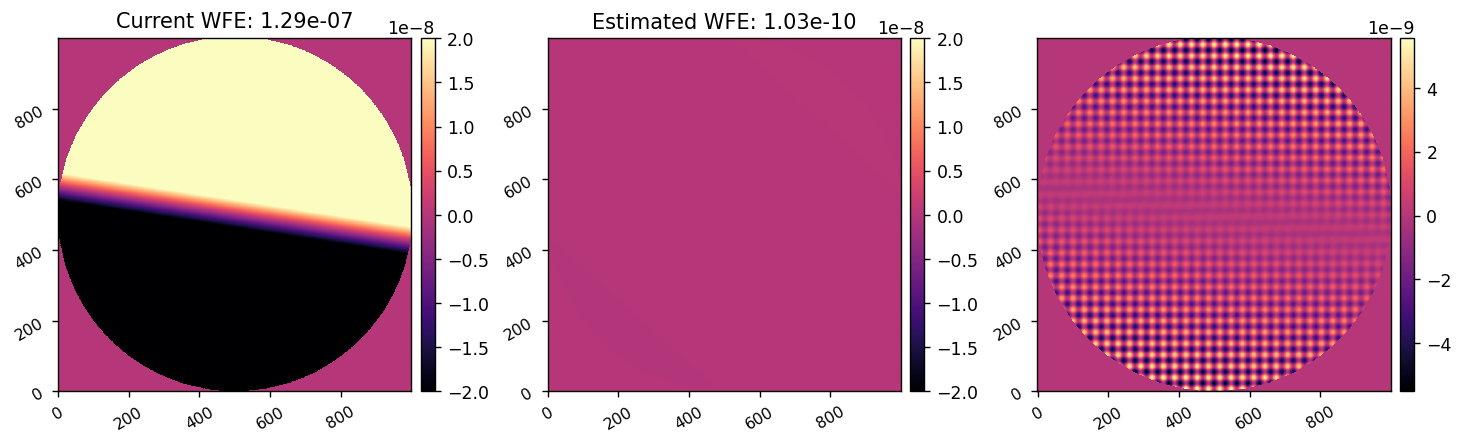

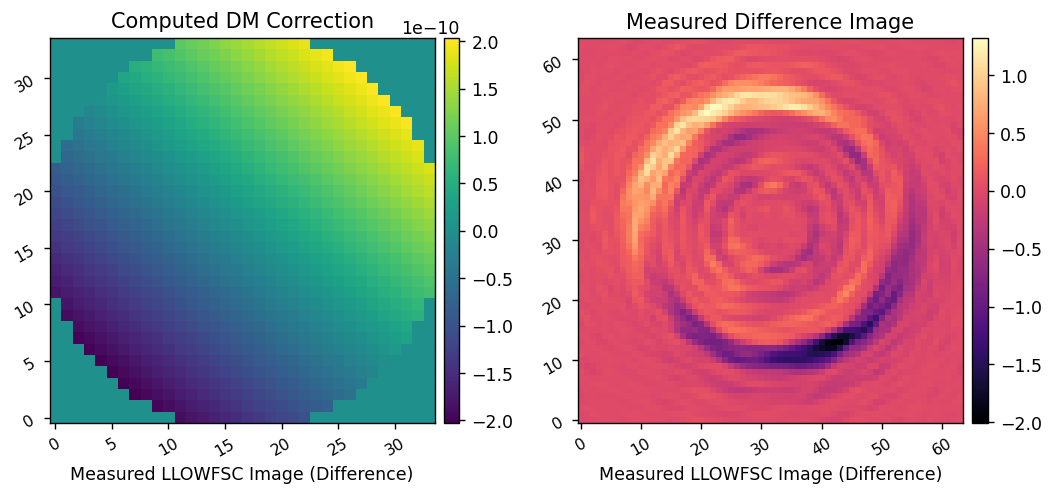

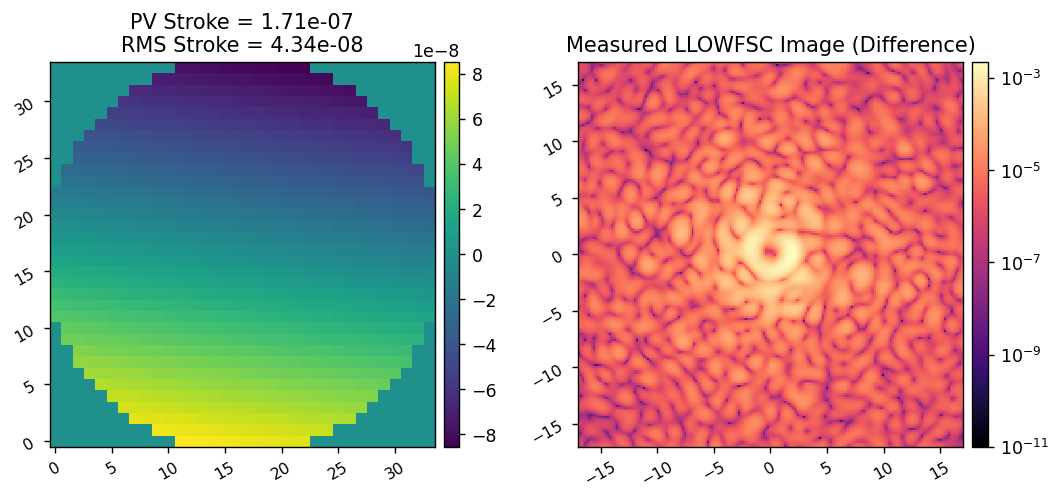

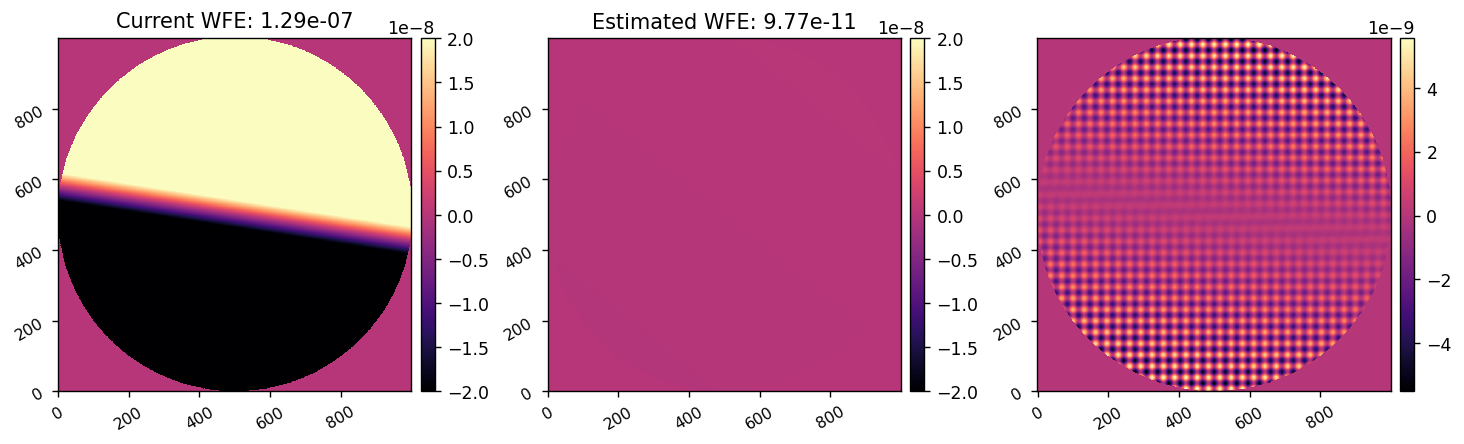

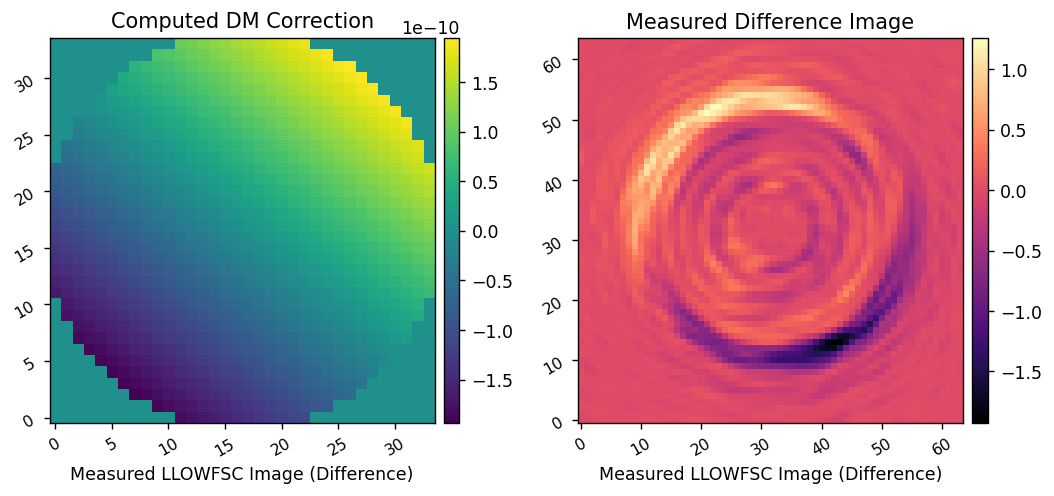

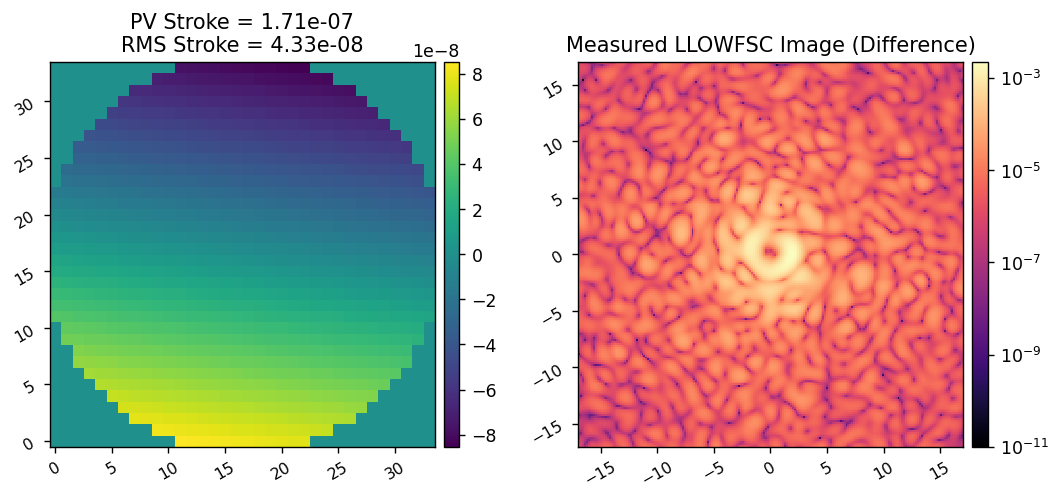

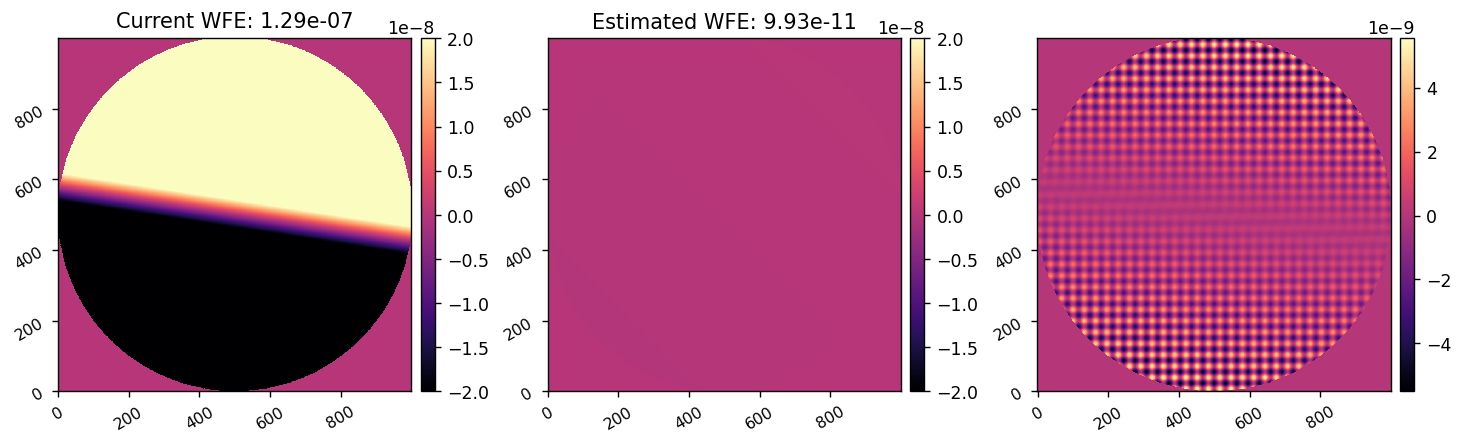

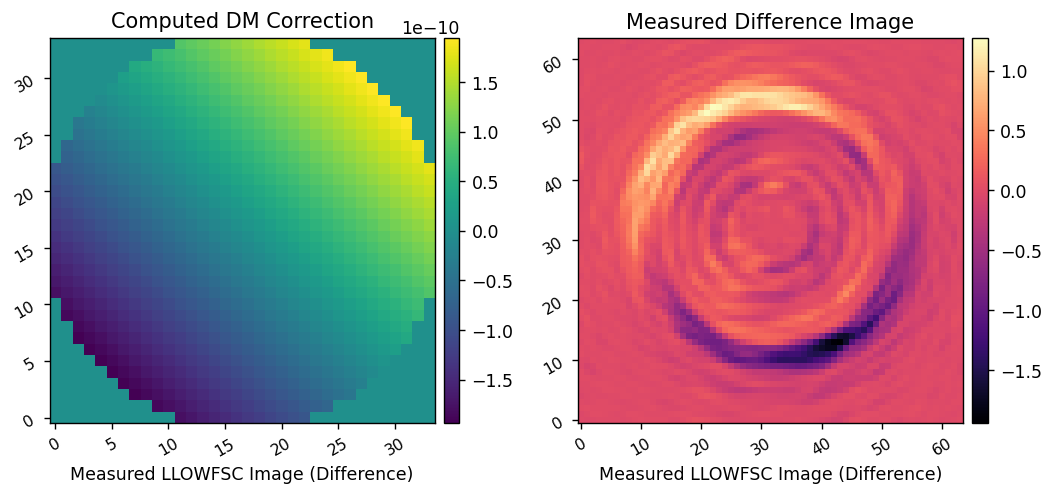

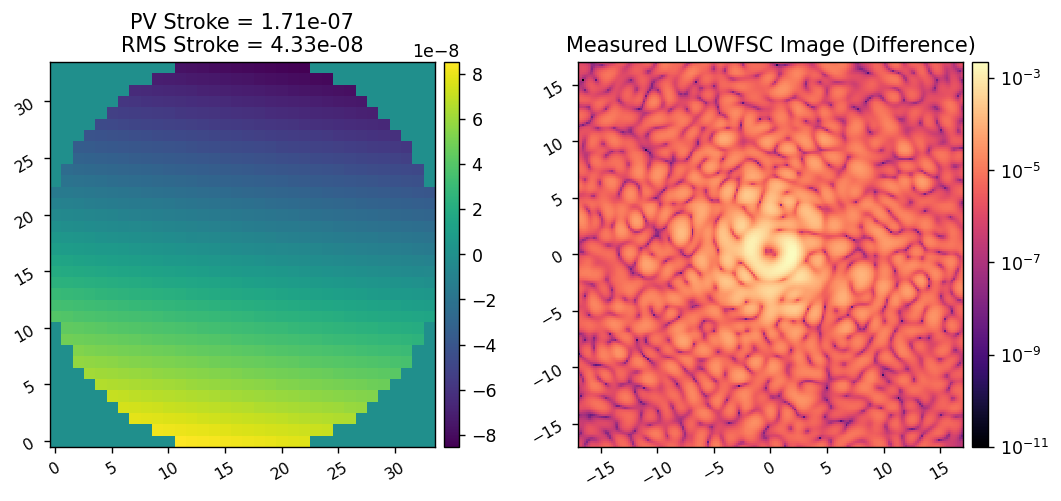

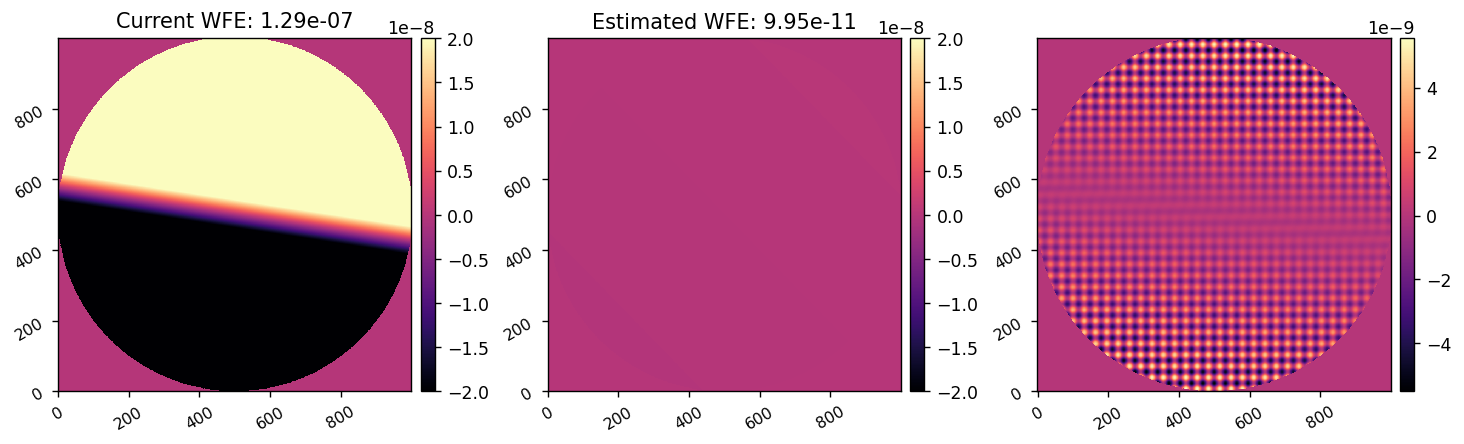

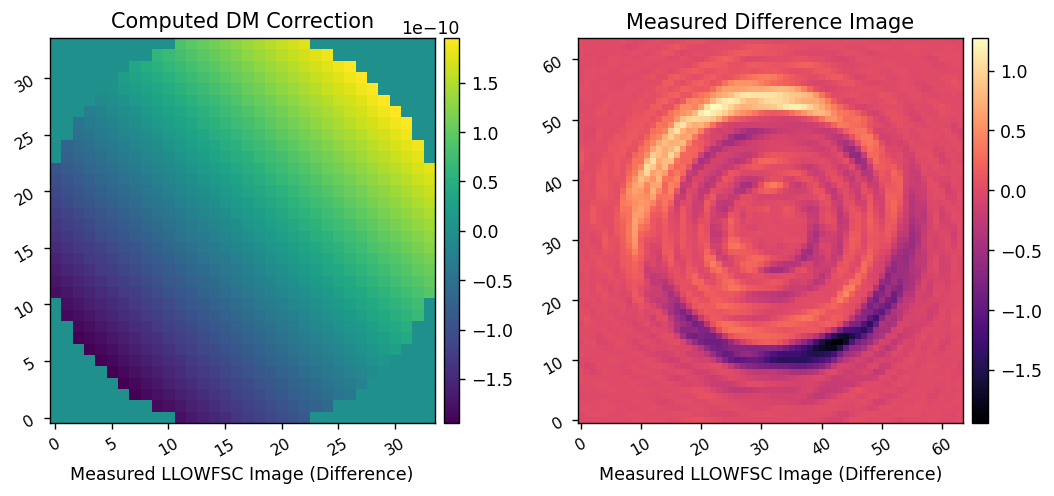

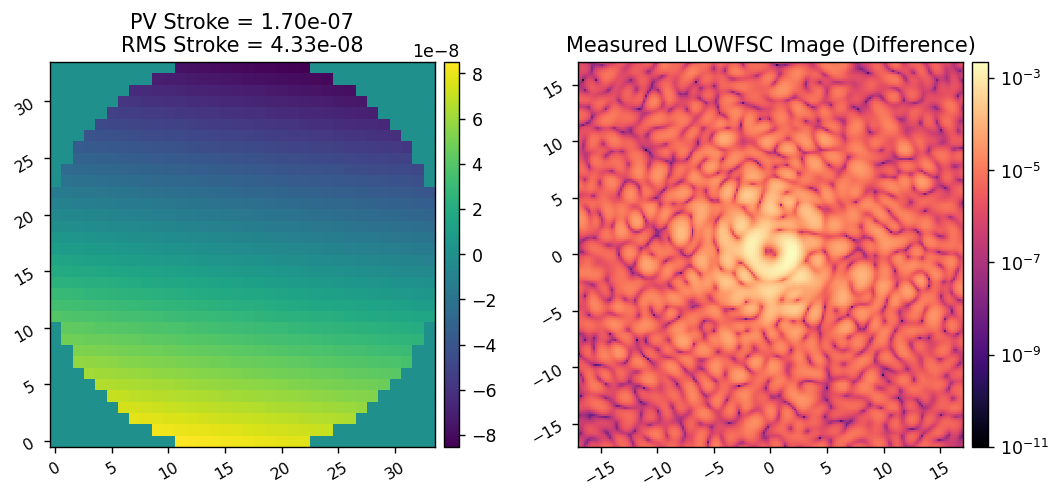

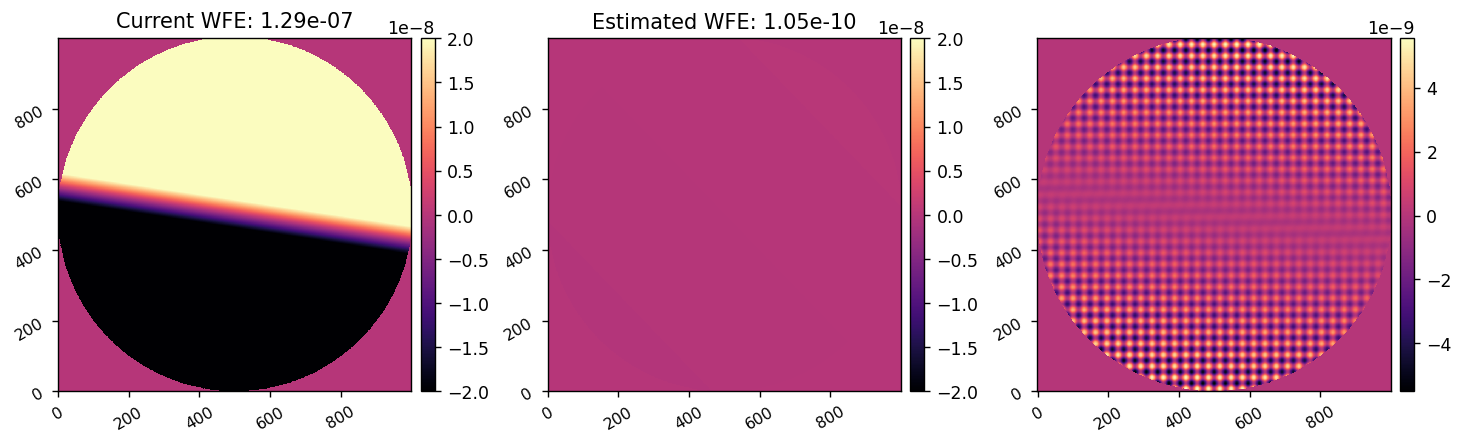

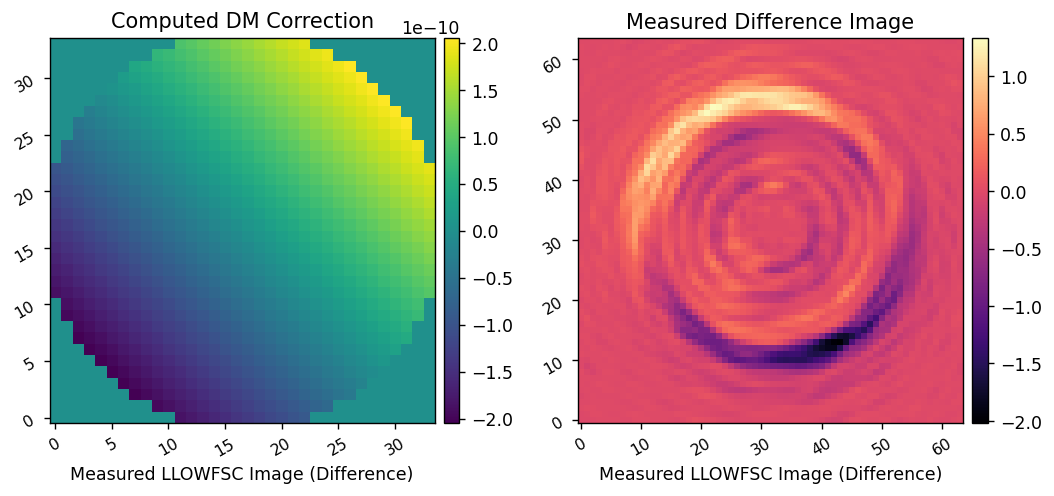

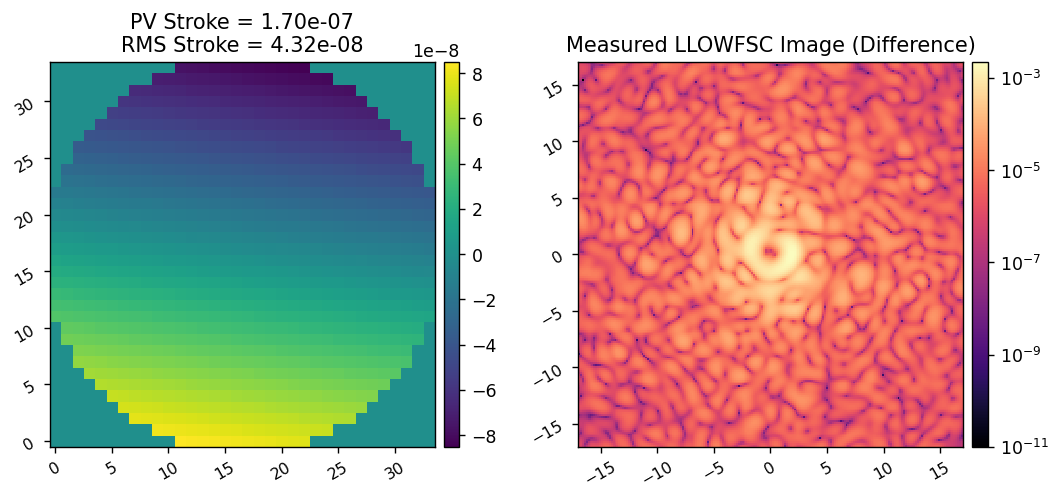

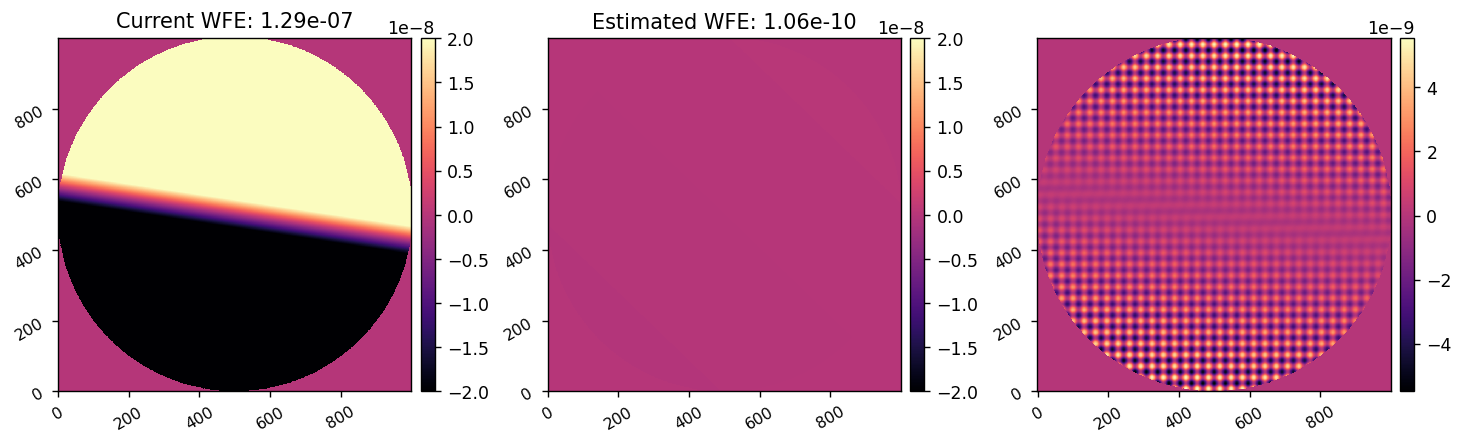

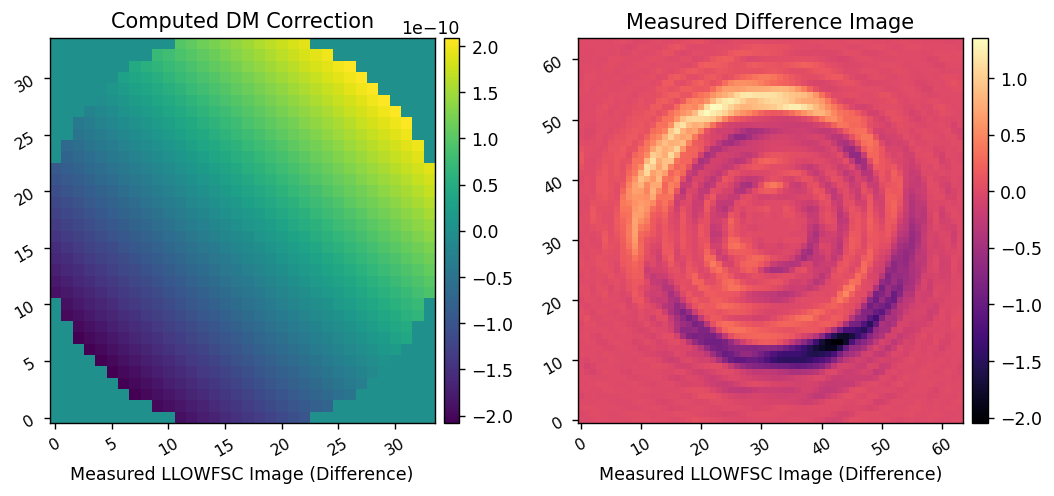

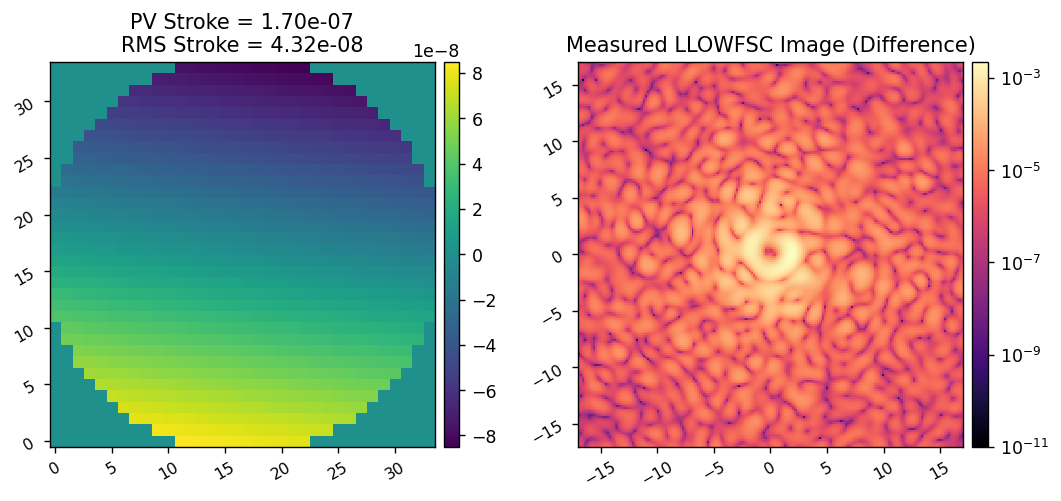

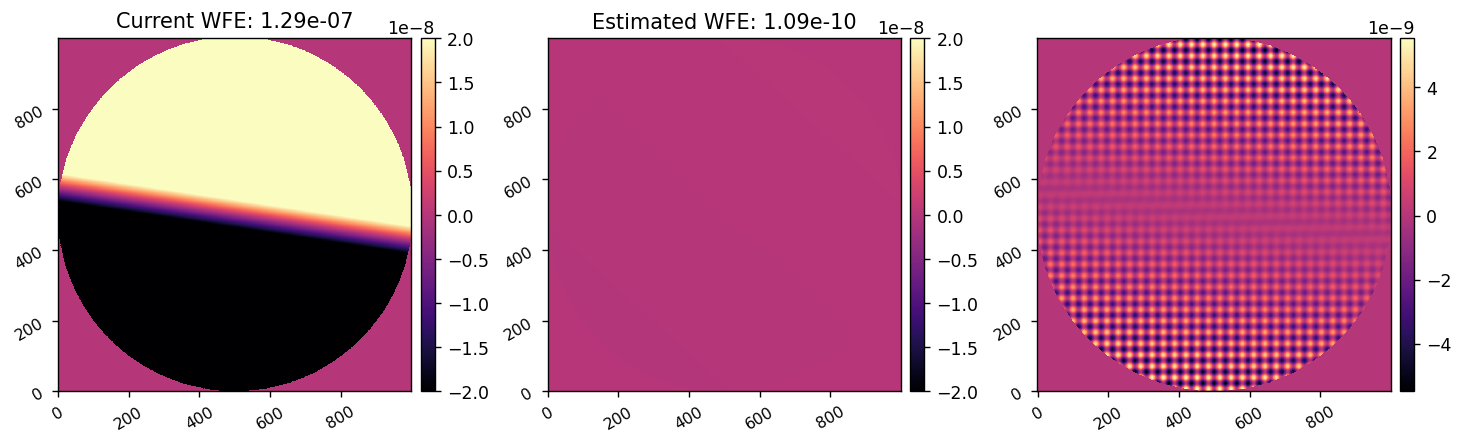

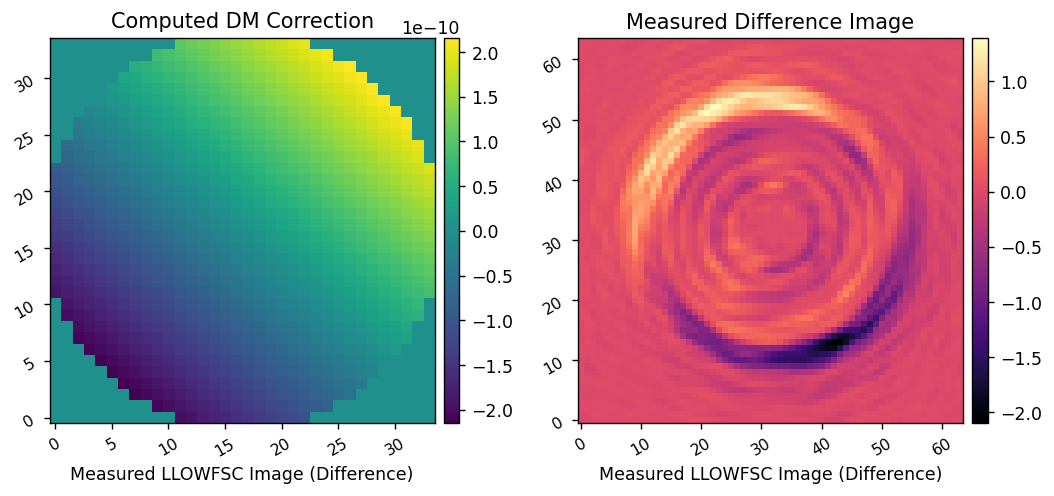

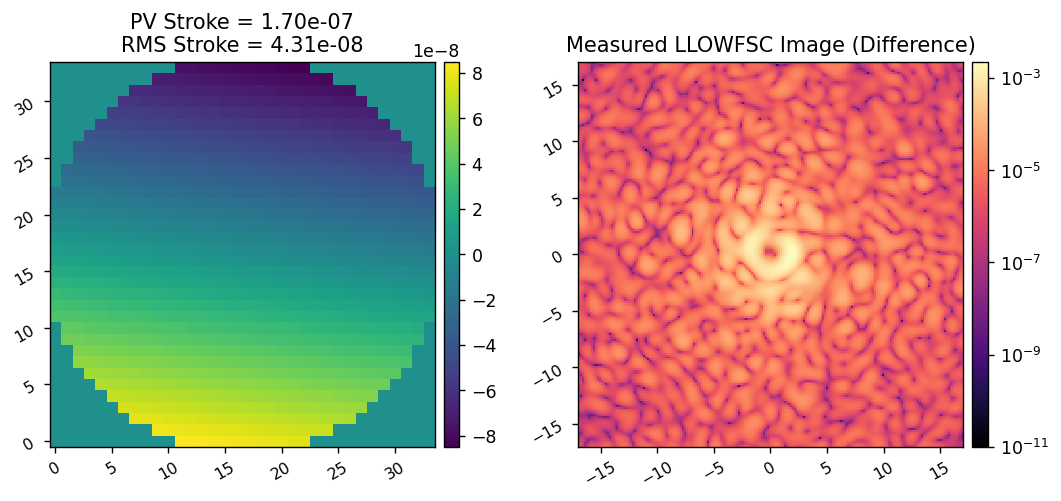

In [46]:
reload(lina)
reload(lina.llowfsc)

N = 2 # how many modes to correct
Nitr = 10

model.reset_dm()

lina.llowfsc.run_model(model, 
                       WFE, 
                      ref_im=im_ref, 
                      control_matrix=control_matrix[:N], 
                      control_modes=dm_zernikes[:N],
                      time_series_coeff=coeff[:,:Nitr], 
                      zernike_modes=zmodes[:N], 
                      coro_sysi=coro_model,
                      plot=True, 
                      )

In [100]:
dm_comb_mask = xp.zeros((model.npix, model.npix))
spacing = npix//34
inds = ((xp.linspace(0, (34-1), 34 ) + 1/2) *spacing - 1/2).astype(int)
inds
dm_comb_mask[inds:inds,inds:inds] = 1

imshow1(dm_comb_mask, npix=128)

TypeError: slice.start must be int or None or have __index__ method: slice(array([  7,  22,  37,  52,  67,  82,  97, 112, 127, 142, 157, 172, 187,
       202, 217, 232, 247, 262, 277, 292, 307, 322, 337, 352, 367, 382,
       397, 412, 427, 442, 457, 472, 487, 502]), array([  7,  22,  37,  52,  67,  82,  97, 112, 127, 142, 157, 172, 187,
       202, 217, 232, 247, 262, 277, 292, 307, 322, 337, 352, 367, 382,
       397, 412, 427, 442, 457, 472, 487, 502]), None)